In [1]:
"""
A simple example of the Stiefel landing algorithm on PCA problem
"""
from time import time

import matplotlib.pyplot as plt

import torch
import geoopt
from geoopt.optim import RiemannianSGD

from landing_stiefel import LandingStiefelSGD
from plam import PLAMStiefelSGD


torch.manual_seed(0)

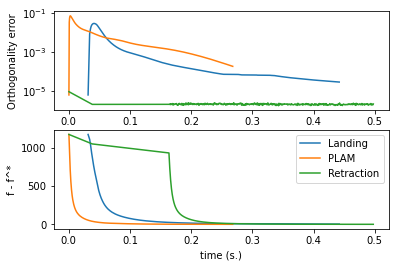

In [2]:
# generate random matrices

m = 1000     # number of samples
n = 100      # dimension of samples
p = 50       # number of principal components
batch_size = 1000
noise_level = 1e-3
A = torch.randn(m, p) @ torch.randn(p, n)
A += noise_level*torch.randn(m, n)
init_weights = torch.randn(n, p)

device = 'cpu'
A = A.to(device)
init_weights = init_weights.to(device)

# Compute the exact solution using SVD
_, _, vh = torch.linalg.svd(A, full_matrices = False)
x_star = vh[:p,:].T

# Objective: min -(1/2) * \| AX \|^2_F
loss_star = -.5 * (torch.matmul(A, x_star) ** 2).sum() / m
loss_star = loss_star.item()


method_names = ["Landing", "PLAM", "Retraction"] # "Retraction",
methods =  [LandingStiefelSGD, PLAMStiefelSGD, RiemannianSGD] # RiemannianSGD

learning_rate = 1e-3

f, axes = plt.subplots(2, 1)
for method_name, method, n_epochs in zip(method_names, methods, [500, 500, 500]):
    iterates = []
    loss_list = []
    time_list = []

    param = geoopt.ManifoldParameter(
        init_weights.clone(), manifold=geoopt.Stiefel(canonical=False)
    )
    with torch.no_grad():
        param.proj_()
    optimizer = method((param,), lr=learning_rate)
    t0 = time()
    for epoch in range(n_epochs):

        optimizer.zero_grad()
        idx = epoch % (m // batch_size)
        a = A[idx * batch_size: (idx + 1) * batch_size]
        loss = -.5 * (torch.matmul(a, param) ** 2).sum() / batch_size
        loss.backward()
        time_list.append(time() - t0)
        loss_list.append(loss.item() - loss_star)
        iterates.append(param.data.clone())
        optimizer.step()

    distance_list = []
    for matrix in iterates:
        d = (
            torch.norm(matrix.transpose(-1, -2).matmul(matrix) - torch.eye(p, device=matrix.device))
        )
        distance_list.append(d.item())
    axes[0].semilogy(time_list, distance_list, label=method_name)
    axes[1].semilogy(time_list, loss_list, label=method_name)

axes[0].set_xlabel("time (s.)")
axes[1].set_xlabel("time (s.)")
axes[0].set_ylabel("Orthogonality error")
axes[1].set_ylabel("f - f^*")
axes[1].set_yscale('linear')
plt.legend()
plt.show()